<a href="https://colab.research.google.com/github/carloslme/ds-portfolio/blob/main/predictive-analytics/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Predictive Analytics is a process of statistical techniques derived from data mining, machine learning and predictive modeling that obtain current and historical events to predict future events or unknown outcomes in the future.

The goal of this exercise is to build a machine learning pipeline for predictive analytics using this open dataset: https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5, which shows the road incidents in Mexico City during february 2021 in the 16 town halls.

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Ingestion

## Getting data from website 

In [2]:
!pip install requests

In [3]:
import requests

In [4]:
res = requests.get('https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/c6b0fe65-137c-40d6-99c9-6c527f9b29c4/download/___')

In [5]:
res.raise_for_status()
csv_file = open('incidentes-viales-c5.csv', 'wb')
for chunk in res.iter_content(100000):
  csv_file.write(chunk)

csv_file.close()

## Getting data dictionary
Let's understand the meaning of each column. 

Original Data Dictionary can be found [here](https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/49b5360c-5922-46bd-b4f8-ed0225d5ddbf/download/diccionario-de-datos-de-incidentes-viales.xlsx).

|Column|Description|
|------|-----------|
folio | Only alphanumeric code assigned to each one of the incidents generated by C5 and C2
fecha_creacion | Folio event opening date
hora_creacion | Folio event opening time
dia_semana | Folio event opening day 
fecha_cierre | Folio event closure date
hora_cierre | Folio event closure time
incidente_c4 | Type of incident
delegacion_inicio | Town hall where the incident was reported
latitud | Lattitude
longitud | Longitude
codigo_cierre | Code generated to the incident ince it was closed
clas_con_f_alarma | Incident classification
tipo_entrada | How the incident was reported 
delegacion_cierre | Town hall where the incident was closed

# Data Exploration 

## Describe data structure

In [6]:
incidents = pd.read_csv('/content/incidentes-viales-c5.csv')
incidents.head()

,Unnamed: 0,folio,fecha_creacion,hora_creacion,dia_semana,fecha_cierre,hora_cierre,incidente_c4,delegacion_inicio,latitud,longitud,codigo_cierre,clas_con_f_alarma,tipo_entrada,delegacion_cierre,ano,mes
0,1,C5/210201/04663,01/02/2021,19:14:39,Lunes,01/02/2021,20:36:48,accidente-choque con lesionados,GUSTAVO A. MADERO,19.461570,-99.115210,A,URGENCIAS MEDICAS,LLAMADA DEL 911,GUSTAVO A. MADERO,2021,2
1,2,C5/210201/00391,01/02/2021,01:02:02,Lunes,01/02/2021,01:20:09,accidente-choque sin lesionados,GUSTAVO A. MADERO,19.471440,-99.081770,N,EMERGENCIA,LLAMADA DEL 911,GUSTAVO A. MADERO,2021,2
2,3,C5/210201/03815,01/02/2021,16:49:58,Lunes,01/02/2021,19:11:53,accidente-choque con lesionados,MIGUEL HIDALGO,19.440680,-99.190980,A,URGENCIAS MEDICAS,LLAMADA DEL 911,MIGUEL HIDALGO,2021,2
3,4,C5/210201/02068,01/02/2021,11:10:52,Lunes,01/02/2021,12:24:56,accidente-choque sin lesionados,COYOACAN,19.342580,-99.148890,A,EMERGENCIA,LLAMADA DEL 911,COYOACAN,2021,2
4,5,C5/210201/03832,01/02/2021,16:52:41,Lunes,01/02/2021,17:38:14,accidente-choque con lesionados,TLALPAN,19.200021,-99.138111,N,URGENCIAS MEDICAS,LLAMADA DEL 911,TLALPAN,2021,2


In [7]:
incidents.describe()

,Unnamed: 0,latitud,longitud,ano,mes
count,12947.000000,12947.000000,12947.000000,12947.0,12947.0
mean,6474.000000,19.380217,-99.131012,2021.0,2.0
std,3737.621302,0.072025,0.061818,0.0,0.0
min,1.000000,19.098188,-99.347260,2021.0,2.0
25%,3237.500000,19.330040,-99.172050,2021.0,2.0
50%,6474.000000,19.380250,-99.134292,2021.0,2.0
75%,9710.500000,19.435890,-99.086560,2021.0,2.0
max,12947.000000,19.576320,-98.952781,2021.0,2.0


In [8]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12947 entries, 0 to 12946
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12947 non-null  int64  
 1   folio              12947 non-null  object 
 2   fecha_creacion     12947 non-null  object 
 3   hora_creacion      12947 non-null  object 
 4   dia_semana         12947 non-null  object 
 5   fecha_cierre       12947 non-null  object 
 6   hora_cierre        12945 non-null  object 
 7   incidente_c4       12947 non-null  object 
 8   delegacion_inicio  12947 non-null  object 
 9   latitud            12947 non-null  float64
 10  longitud           12947 non-null  float64
 11  codigo_cierre      12947 non-null  object 
 12  clas_con_f_alarma  12947 non-null  object 
 13  tipo_entrada       12947 non-null  object 
 14  delegacion_cierre  12947 non-null  object 
 15  ano                12947 non-null  int64  
 16  mes                129

Showing the number of instances (on the vertical axis) that have a given value range (on the horizontal axis)

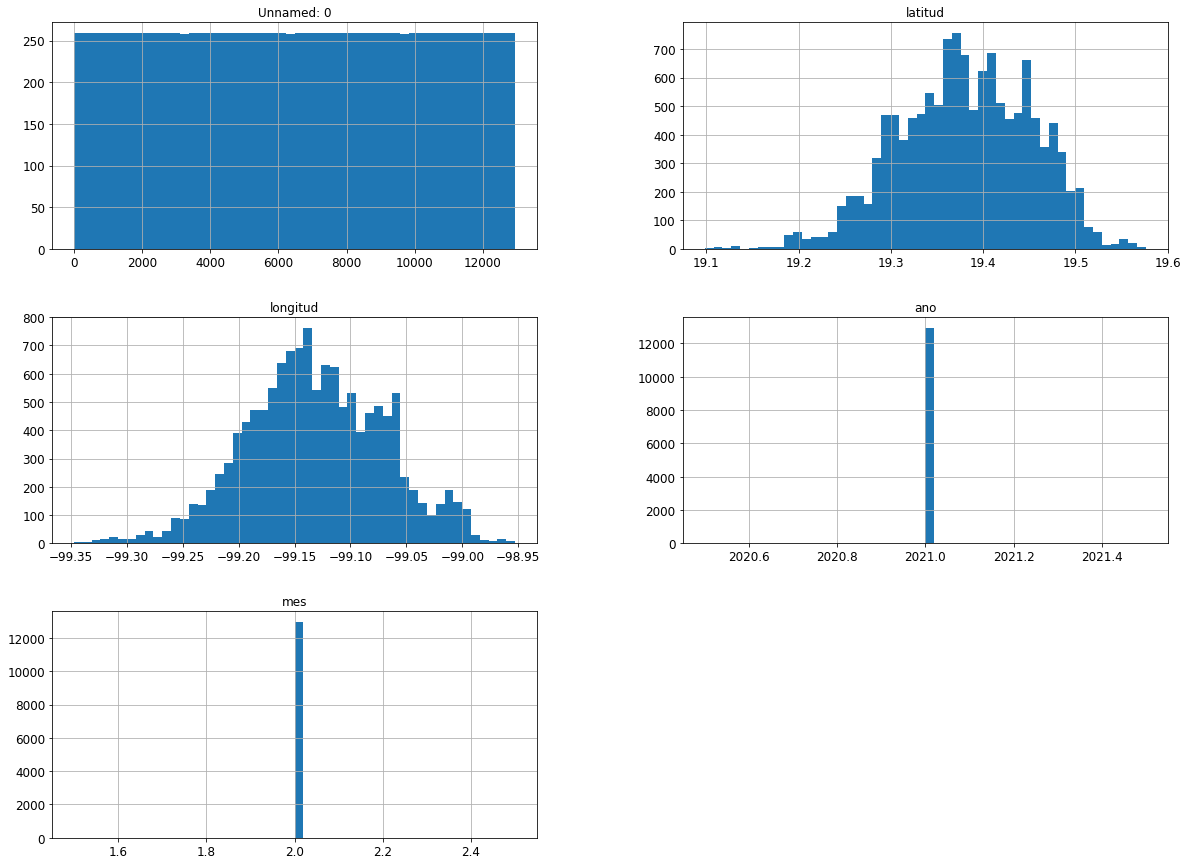

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
incidents.hist(bins=50, figsize=(20,15))
plt.show()

Few things to notice in the above histograms:
1. Not all the fields were plotted
2. The `latitud` and `longitud` data is may be represented in a map to visualize the locations (we already know that there are from Mexico City)
3. The fields `ano` and `mes` have the same just one value each one, they may be deleted later.
4. `Unnamed: 0` field is not relevant, it has to be deleted too

Visualizing the data to have a better overview of how it is distributed with a Kernel Density Estimate (KDE) plot, which is a method for visualizing the distribution of observations in a dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


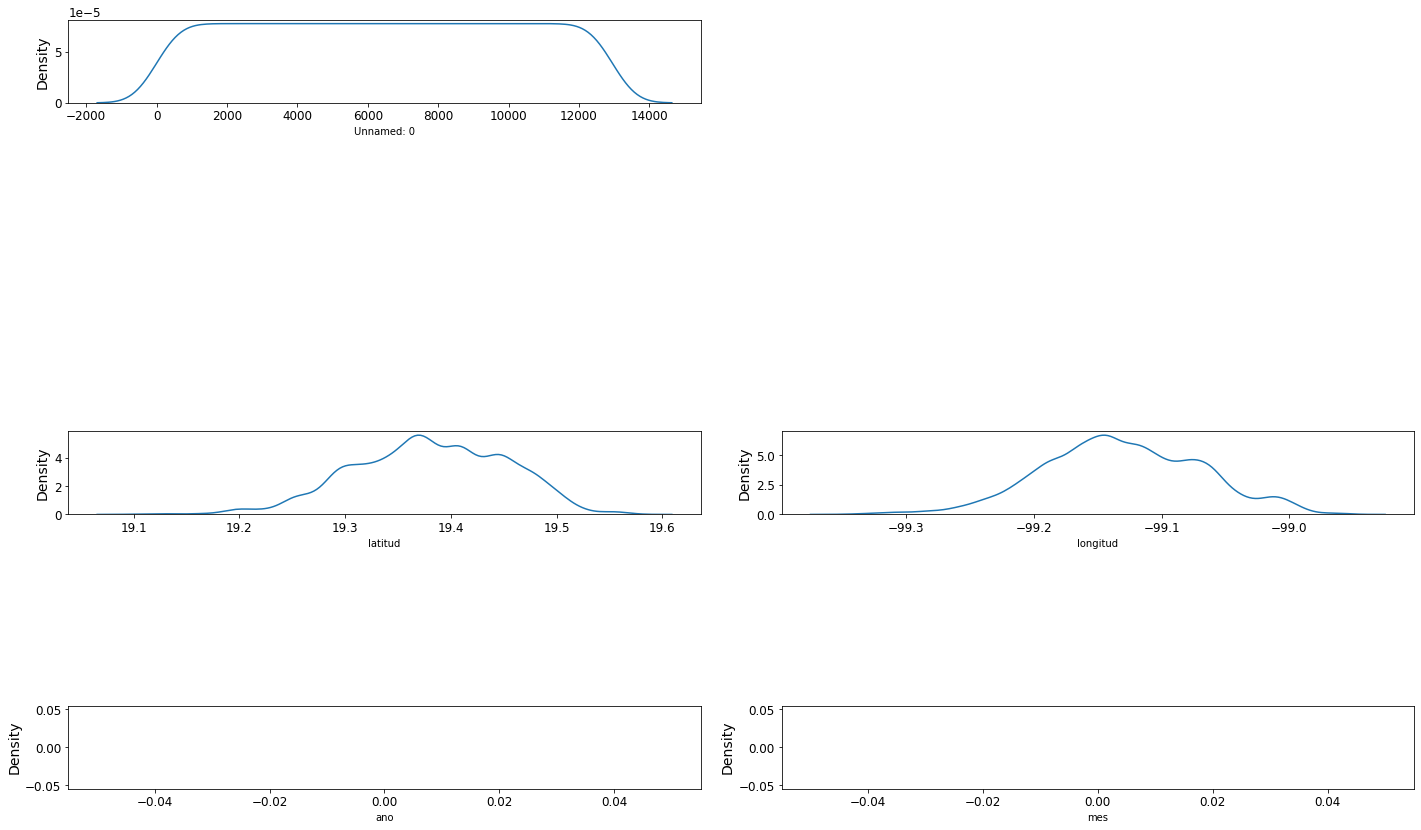

In [10]:
# Plotting Kernel Density Estimate (KDE)
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(30,40))
for i, col in enumerate(incidents.columns):
    if incidents[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

Same things noticed from histograms, there are missing fields such as `fecha_creacion`, `hora_creacion`. and even `dia_semana`.

## Discover and visualize the data to gain insights

### Visualizing Geographical Data
Graphing the geographical information by latitude and longitude and using a scatterplot of all districts

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


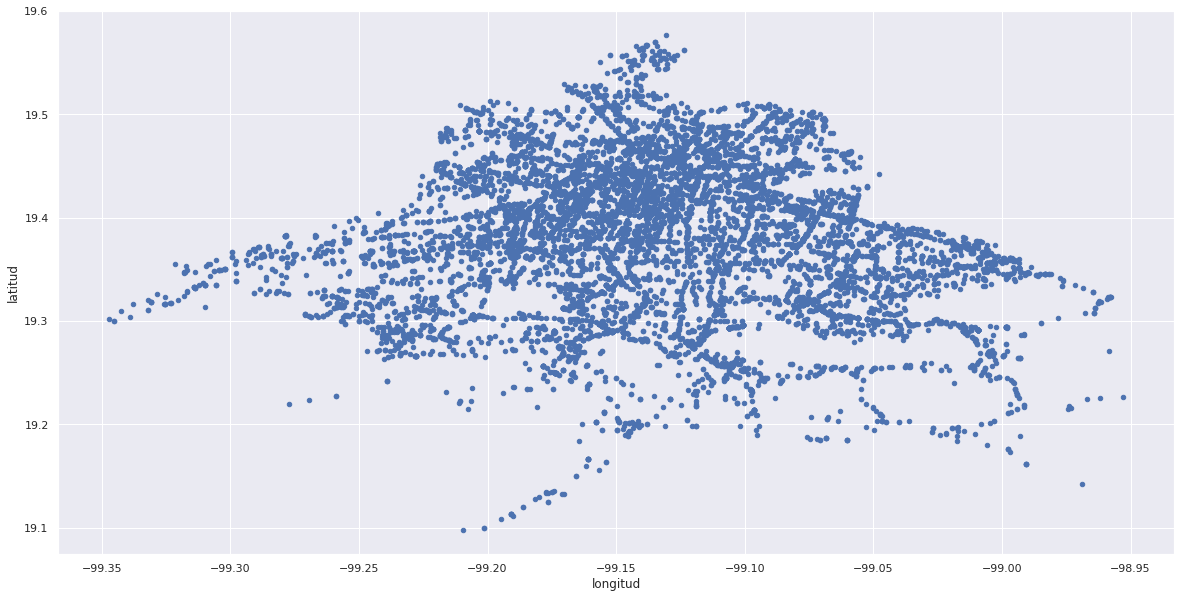

In [12]:
incidents.plot(kind='scatter', x='longitud', y='latitud')

To visualize some particular patterns, the alpha option has to be set to 0.1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


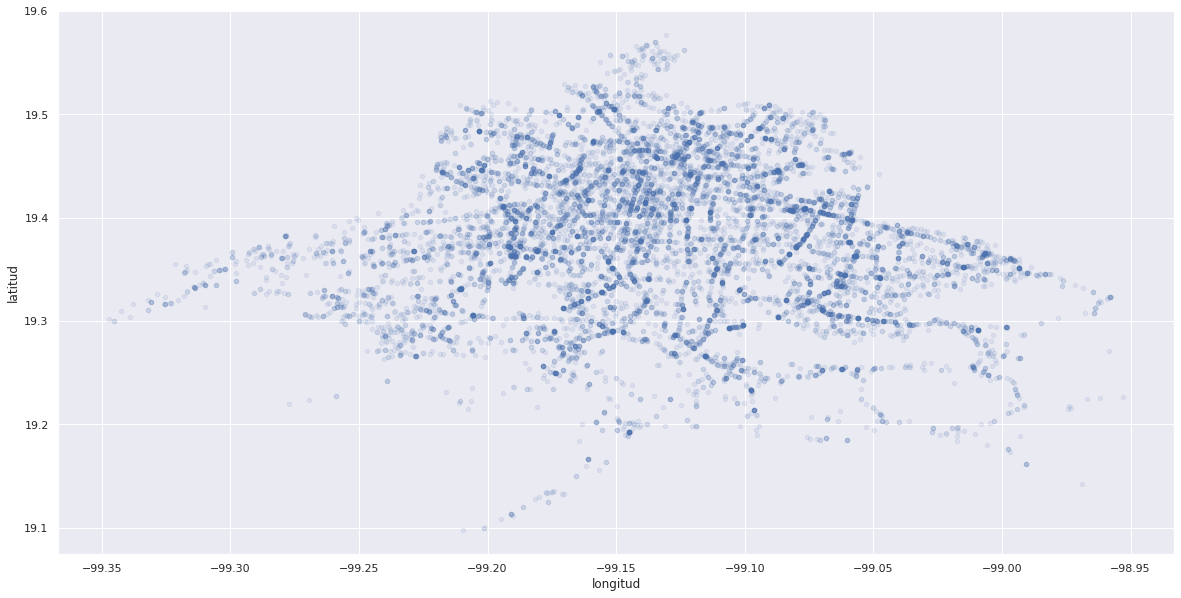

In [13]:
incidents.plot(kind='scatter', x='longitud', y='latitud', alpha=0.1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


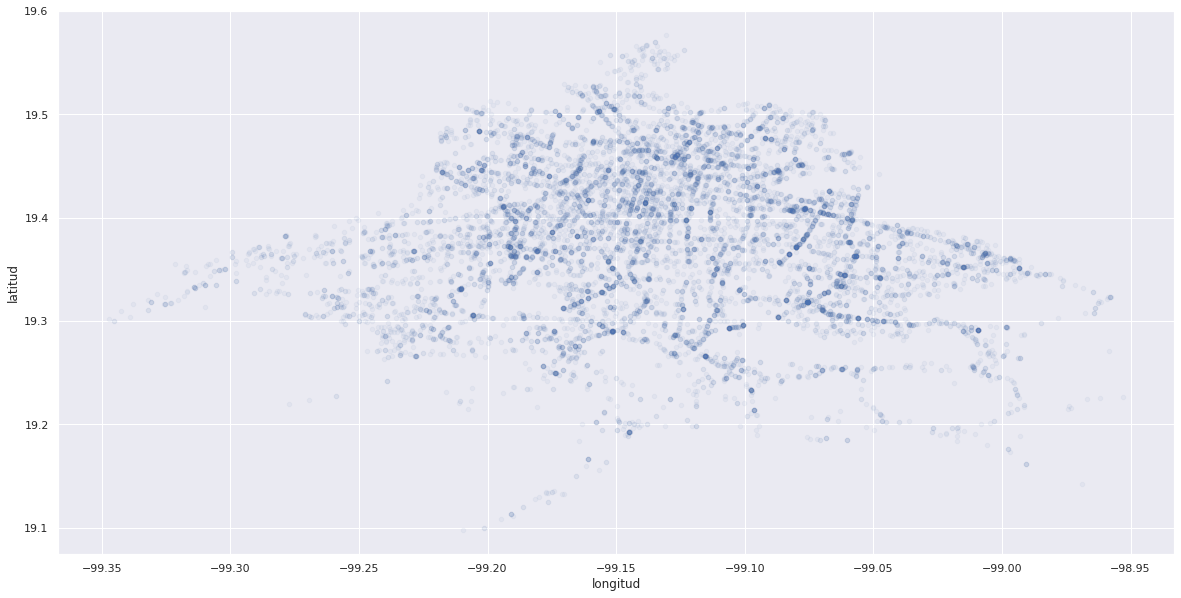

In [14]:
incidents.plot(kind='scatter', x='longitud', y='latitud', alpha=0.05)

We can create a map using the [Matbox API](https://colab.research.google.com/github/la-counts/data-adventures/blob/master/Instructable_6_How_to_Map_Geographic_Data_Using_Coordinates.ipynb?authuser=1#scrollTo=sxb7cAsfVNuY)

In [15]:
!pip install chart-studio

     |████████████████████████████████| 71kB 4.1MB/s 


In [16]:
import chart_studio
from chart_studio import plotly as py
import plotly.tools as tl
import plotly.graph_objs as go
import pandas as pd

# Change API key for Plotly 

chart_studio.tools.set_credentials_file(username='carloslme', api_key='EHfn2j51fBhW5xYh6VM7')

# Add Mapbox access token here 

mapbox_access_token = 'pk.eyJ1IjoiYXNjaHJvY2siLCJhIjoiY2p2NnRoeHc2MDkxbTQ0bnR6aTVwZDNsaCJ9.MA76hkxD3rOGgnVCDBVC9w'

df = pd.read_csv('https://datos.cdmx.gob.mx/dataset/a6d1d483-65d2-4ed9-9687-1932eb0cf70f/resource/c6b0fe65-137c-40d6-99c9-6c527f9b29c4/download/___')


In [17]:

# Save latitude and longitude as variables. In this dataset, the X column is longitude and the Y column is latitude. 

site_lat = df.latitud[:6000]
site_lon = df.longitud[:6000]
locations_name = df.incidente_c4[:6000]

# Generate the data for the map 

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]


# Generate a layout around Los Angeles, zoomed in so we can see the data points 

layout = go.Layout(
    title='CDMX Incidents - First 6000',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=19.432608,
            lon=-99.133209
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)
	
# Generate the figure using the iplot function 
  
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CDMX Incidents - First 6000')

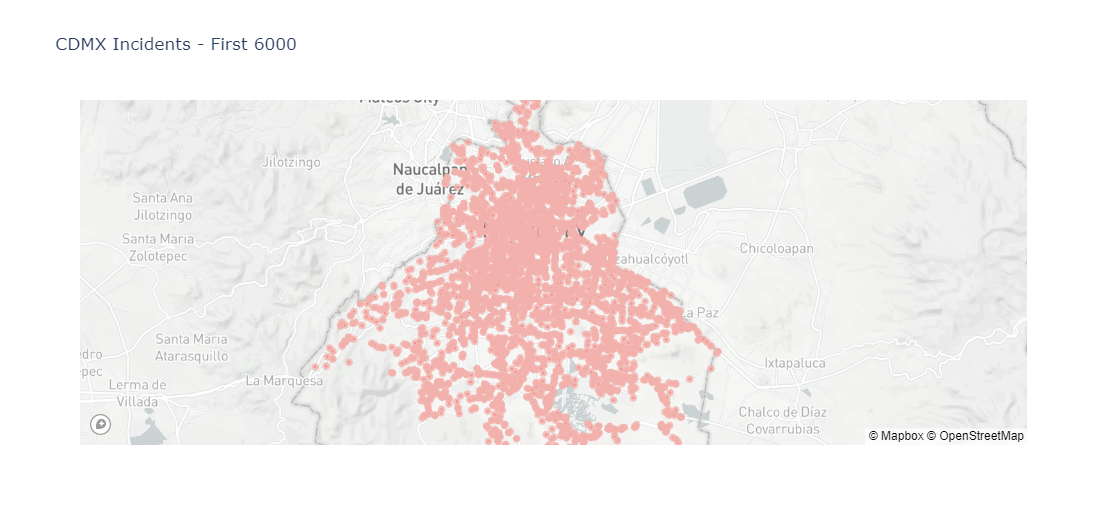

In [18]:

# Save latitude and longitude as variables. In this dataset, the X column is longitude and the Y column is latitude. 

site_lat = df.latitud[6000:12000]
site_lon = df.longitud[6000:12000]
locations_name = df.incidente_c4[6000:12000]

# Generate the data for the map 

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=3,
            color='rgb(255, 0, 0)',
            opacity=1
        ),
        text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        hoverinfo='none'
    )]


# Generate a layout around Los Angeles, zoomed in so we can see the data points 

layout = go.Layout(
    title='CDMX Incidents - Last 6000',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=19.432608,
            lon=-99.133209
        ),
        pitch=0,
        zoom=10,
        style='light'
    ),
)
	
# Generate the figure using the iplot function 
  
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CDMX Incidents - Last 6000')

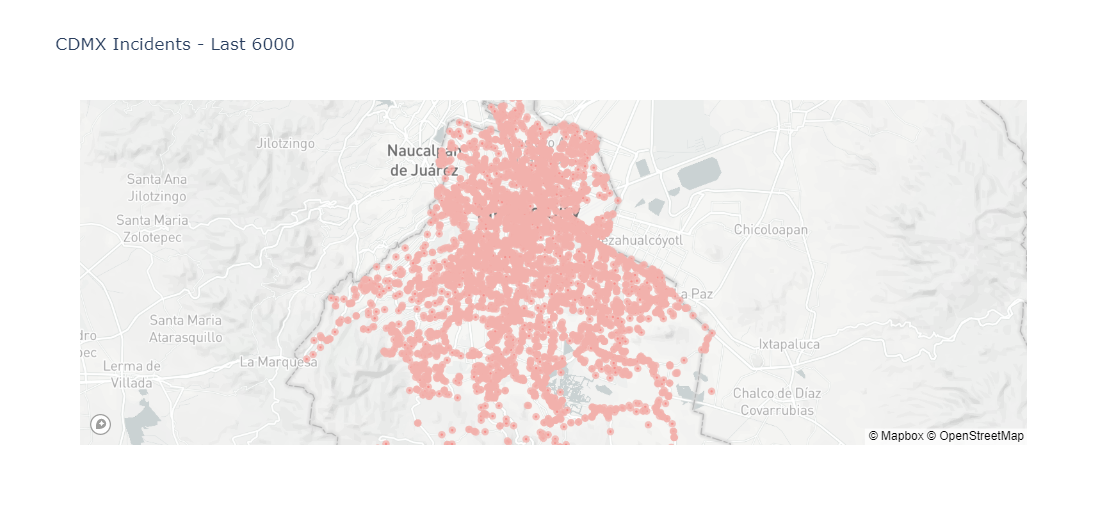

# Data Preprocessing

## Remove irrelevant columns
Apparently, the columns that seems to not contribute anything for this analysis are the following:
* `Unnamed` - Just the rows numbers
* `fecha_creacion` - irrelevant
* `fecha_cierre` - not necessary for prediction
* `hora_cierre` - not necessary for prediction
* `delegacion_inicio` - not necessary for prediction
* `delegacion_cierre` - not necessary for prediction
* `codigo_cierre` - not necessary for prediction
* `ano` - can be inferred by `fecha_creacion`
* `mes` - `fecha_creacion`

In [19]:
incidents.drop(['Unnamed: 0', 'folio', 'fecha_creacion', 'fecha_cierre', 'hora_cierre', 'delegacion_inicio', 'codigo_cierre', 'delegacion_cierre', 'ano', 'mes'], axis=1, inplace=True)

Exploring data after remove irrelevant columns

In [20]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12947 entries, 0 to 12946
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hora_creacion      12947 non-null  object 
 1   dia_semana         12947 non-null  object 
 2   incidente_c4       12947 non-null  object 
 3   latitud            12947 non-null  float64
 4   longitud           12947 non-null  float64
 5   clas_con_f_alarma  12947 non-null  object 
 6   tipo_entrada       12947 non-null  object 
dtypes: float64(2), object(5)
memory usage: 708.2+ KB


In [21]:
incidents.head(10)

,hora_creacion,dia_semana,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada
0,19:14:39,Lunes,accidente-choque con lesionados,19.461570,-99.115210,URGENCIAS MEDICAS,LLAMADA DEL 911
1,01:02:02,Lunes,accidente-choque sin lesionados,19.471440,-99.081770,EMERGENCIA,LLAMADA DEL 911
2,16:49:58,Lunes,accidente-choque con lesionados,19.440680,-99.190980,URGENCIAS MEDICAS,LLAMADA DEL 911
3,11:10:52,Lunes,accidente-choque sin lesionados,19.342580,-99.148890,EMERGENCIA,LLAMADA DEL 911
4,16:52:41,Lunes,accidente-choque con lesionados,19.200021,-99.138111,URGENCIAS MEDICAS,LLAMADA DEL 911
5,19:23:09,Lunes,accidente-motociclista,19.382470,-99.060990,URGENCIAS MEDICAS,LLAMADA DEL 911
6,01:11:09,Lunes,accidente-choque sin lesionados,19.484860,-99.069640,EMERGENCIA,LLAMADA DEL 911
7,11:15:17,Lunes,accidente-choque sin lesionados,19.463890,-99.125270,EMERGENCIA,LLAMADA DEL 911
8,16:54:48,Lunes,lesionado-atropellado,19.428370,-99.095550,URGENCIAS MEDICAS,LLAMADA DEL 911
9,16:52:03,Lunes,accidente-choque con prensados,19.199580,-99.141820,URGENCIAS MEDICAS,LLAMADA DEL 911


In [22]:
incidents.describe()

,latitud,longitud
count,12947.000000,12947.000000
mean,19.380217,-99.131012
std,0.072025,0.061818
min,19.098188,-99.347260
25%,19.330040,-99.172050
50%,19.380250,-99.134292
75%,19.435890,-99.086560
max,19.576320,-98.952781


## Handling text and categorical attributes¶


There are several columns with text and categorical attributes. Most ML algorithms prefer to work with numbers, so it's a good idea to convert these categories from text to numbers by using the `OrdinalEncoder` class found in `sklearn`.

In [23]:
incidents['dia_semana'].value_counts()

Sábado       2460
Viernes      2135
Domingo      2027
Martes       1635
Lunes        1572
Miércoles    1572
Jueves       1546
Name: dia_semana, dtype: int64

In [24]:
incidents['clas_con_f_alarma'].value_counts()

URGENCIAS MEDICAS    6471
EMERGENCIA           6410
FALSA ALARMA           51
DELITO                 15
Name: clas_con_f_alarma, dtype: int64

In [25]:
incidents['incidente_c4'].value_counts()

accidente-choque sin lesionados                  6004
accidente-choque con lesionados                  3571
accidente-motociclista                           1392
lesionado-atropellado                            1329
accidente-volcadura                               236
accidente-ciclista                                177
accidente-persona atrapada / desbarrancada         51
mi ciudad-calle-incidente de tránsito              46
accidente-vehículo atrapado-varado                 32
accidente-choque con prensados                     28
cadáver-accidente automovilístico                  22
cadáver-atropellado                                15
accidente-otros                                    12
sismo-choque con lesionados                        11
detención ciudadana-atropellado                     9
detención ciudadana-accidente automovilístico       6
accidente-vehiculo desbarrancado                    4
accidente-ferroviario                               1
sismo-persona atropellada   

In [26]:
incidents['tipo_entrada'].value_counts()

LLAMADA DEL 911     11159
RADIO                 813
BOTÓN DE AUXILIO      804
APLICATIVOS            60
REDES                  57
CÁMARA                 34
LLAMADA APP911         20
Name: tipo_entrada, dtype: int64

In [27]:
incidents_cat = incidents[['dia_semana', 'clas_con_f_alarma', 'incidente_c4', 'tipo_entrada']]
incidents_cat.head(10)

,dia_semana,clas_con_f_alarma,incidente_c4,tipo_entrada
0,Lunes,URGENCIAS MEDICAS,accidente-choque con lesionados,LLAMADA DEL 911
1,Lunes,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
2,Lunes,URGENCIAS MEDICAS,accidente-choque con lesionados,LLAMADA DEL 911
3,Lunes,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
4,Lunes,URGENCIAS MEDICAS,accidente-choque con lesionados,LLAMADA DEL 911
5,Lunes,URGENCIAS MEDICAS,accidente-motociclista,LLAMADA DEL 911
6,Lunes,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
7,Lunes,EMERGENCIA,accidente-choque sin lesionados,LLAMADA DEL 911
8,Lunes,URGENCIAS MEDICAS,lesionado-atropellado,LLAMADA DEL 911
9,Lunes,URGENCIAS MEDICAS,accidente-choque con prensados,LLAMADA DEL 911


Each of this values represents a catagory. This is called categorical attribute. Most ML algorithms prefer to work with numbers, so it's a good idea to convert theses categories from text to numbers by using de `OrdinalEncoder` class:

In [28]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [29]:
incidents_cat_encoded = ordinal_encoder.fit_transform(incidents_cat)

In [30]:
incidents_cat_encoded[:10]

array([[ 2.,  3.,  0.,  4.],
       [ 2.,  1.,  2.,  4.],
       [ 2.,  3.,  0.,  4.],
       [ 2.,  1.,  2.,  4.],
       [ 2.,  3.,  0.,  4.],
       [ 2.,  3.,  5.,  4.],
       [ 2.,  1.,  2.,  4.],
       [ 2.,  1.,  2.,  4.],
       [ 2.,  3., 15.,  4.],
       [ 2.,  3.,  1.,  4.]])

In [31]:
ordinal_encoder.categories_

[array(['Domingo', 'Jueves', 'Lunes', 'Martes', 'Miércoles', 'Sábado',
        'Viernes'], dtype=object),
 array(['DELITO', 'EMERGENCIA', 'FALSA ALARMA', 'URGENCIAS MEDICAS'],
       dtype=object),
 array(['accidente-choque con lesionados',
        'accidente-choque con prensados',
        'accidente-choque sin lesionados', 'accidente-ciclista',
        'accidente-ferroviario', 'accidente-motociclista',
        'accidente-otros', 'accidente-persona atrapada / desbarrancada',
        'accidente-vehiculo desbarrancado',
        'accidente-vehículo atrapado-varado', 'accidente-volcadura',
        'cadáver-accidente automovilístico', 'cadáver-atropellado',
        'detención ciudadana-accidente automovilístico',
        'detención ciudadana-atropellado', 'lesionado-atropellado',
        'mi ciudad-calle-incidente de tránsito',
        'sismo-choque con lesionados', 'sismo-persona atropellada'],
       dtype=object),
 array(['APLICATIVOS', 'BOTÓN DE AUXILIO', 'CÁMARA', 'LLAMADA APP911',
   

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

# Personalized DataframeSelector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Pipeline for the numerical attributes

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["latitud", "longitud", "hora_creacion"])),
    ])

Pipeline for the categorical attributes

In [34]:
cat_pipeline = Pipeline([
          ("select_cat", DataFrameSelector(['dia_semana', 'clas_con_f_alarma', 'incidente_c4', 'tipo_entrada'])),
          ("cat_encoder", OrdinalEncoder()),
])

cat_pipeline.fit_transform(incidents)

array([[2., 3., 0., 4.],
       [2., 1., 2., 4.],
       [2., 3., 0., 4.],
       ...,
       [0., 3., 0., 4.],
       [0., 1., 2., 4.],
       [0., 1., 2., 1.]])

Joining the numerical and categorical pipelines

In [35]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [36]:
incidents_prep = preprocess_pipeline.fit_transform(incidents)
incidents_prep

array([[19.46157003, -99.11521008, '19:14:39', ..., 3.0, 0.0, 4.0],
       [19.47143997, -99.08177004, '01:02:02', ..., 1.0, 2.0, 4.0],
       [19.44068004, -99.19098000000001, '16:49:58', ..., 3.0, 0.0, 4.0],
       ...,
       [19.39677, -99.23711999999999, '22:45:59', ..., 3.0, 0.0, 4.0],
       [19.48166001, -99.21855996, '22:48:36', ..., 1.0, 2.0, 4.0],
       [19.244195, -99.108017, '19:46:33', ..., 1.0, 2.0, 1.0]],
      dtype=object)

## Reporting structures
Let's find any structures that can be found analyzing this dataset once it was cleaned.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

incidents_report = pd.DataFrame(incidents_prep, columns = ['latitud', 'longitud', 'hora_creacion','dia_semana', 'clas_con_f_alarma', 'incidente_c4', 'tipo_entrada'])

plt.figure(figsize=(30,40))
for i, col in enumerate(incidents_report.columns):
    if incidents_report[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents_report[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

<Figure size 2160x2880 with 0 Axes>

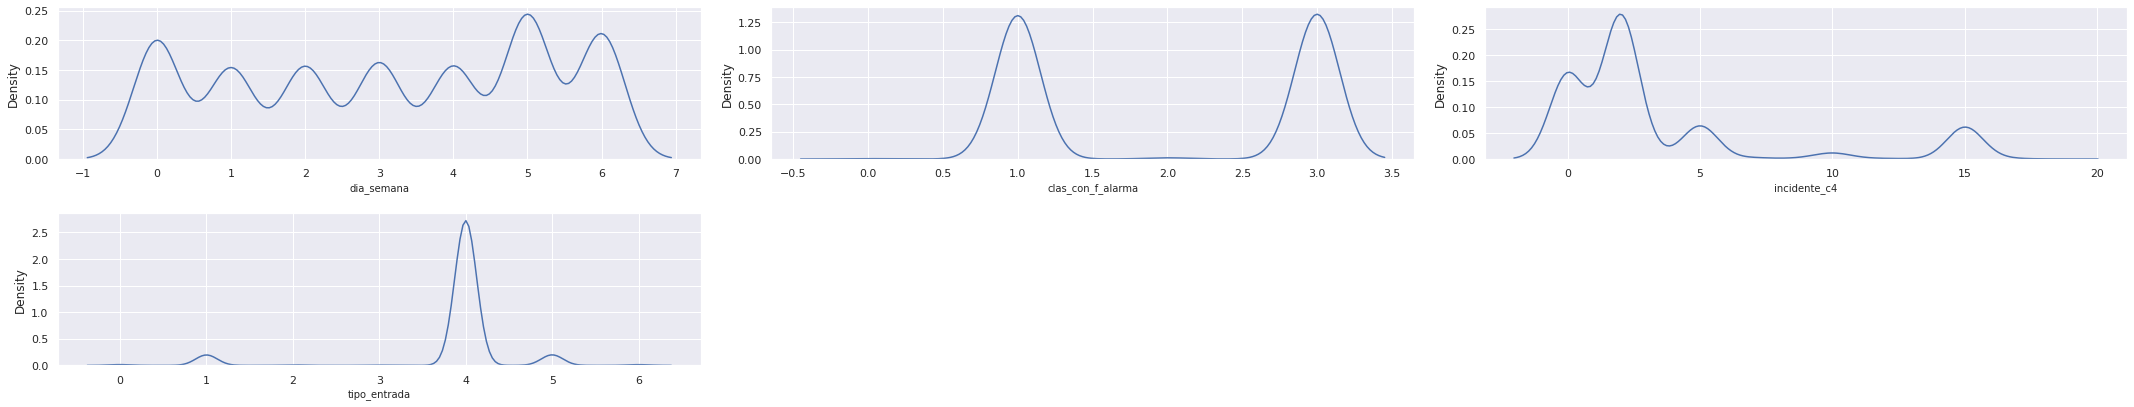

In [41]:
incidents_report_aux = incidents_report.copy()
incidents_report_aux['dia_semana'] = pd.to_numeric(incidents_report['dia_semana'])
incidents_report_aux['clas_con_f_alarma'] = pd.to_numeric(incidents_report['clas_con_f_alarma'])
incidents_report_aux['incidente_c4'] = pd.to_numeric(incidents_report['incidente_c4'])
incidents_report_aux['tipo_entrada'] = pd.to_numeric(incidents_report['tipo_entrada'])
plt.figure(figsize=(30,60))
for i, col in enumerate(incidents_report_aux.columns):
    if incidents_report_aux[col].dtype != 'object':
        ax = plt.subplot(21, 3, i+1)
        sns.kdeplot(incidents_report_aux[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

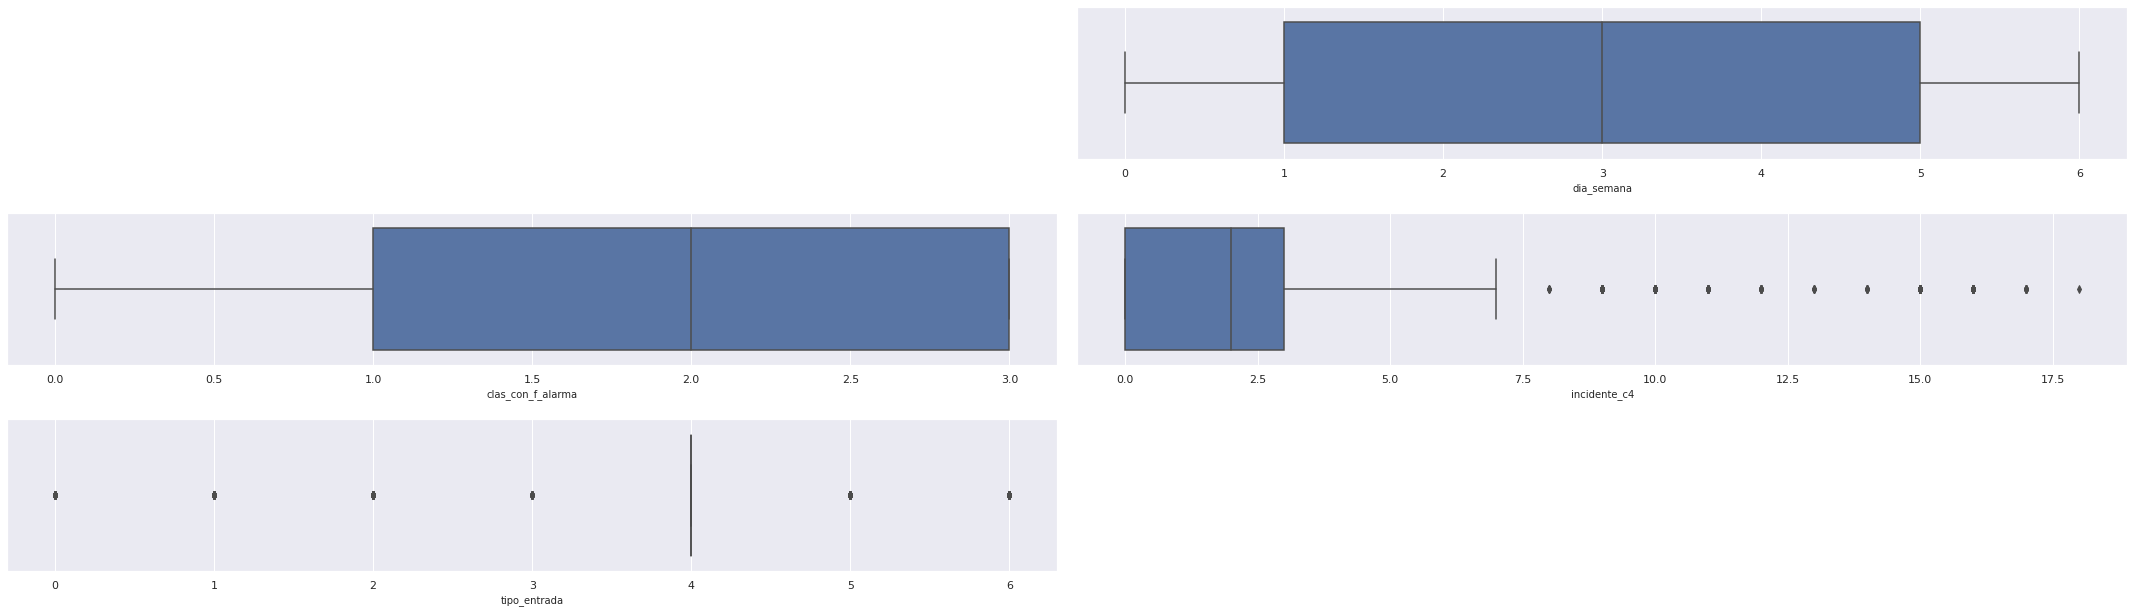

In [43]:
plt.figure(figsize=(30,60))
for i, col in enumerate(incidents_report_aux.columns):
    if incidents_report_aux[col].dtype != 'object':
        ax = plt.subplot(21, 2, i+1)
        sns.boxplot(incidents_report_aux[col], ax=ax)
        plt.xlabel(col, fontsize=10)
        plt.tight_layout(pad=2.0)
        
plt.show()

## Exploring data by text attributes

The categories encoded only works for the ML algoritms. Let's explore the text attributes using the original dataset.

[]

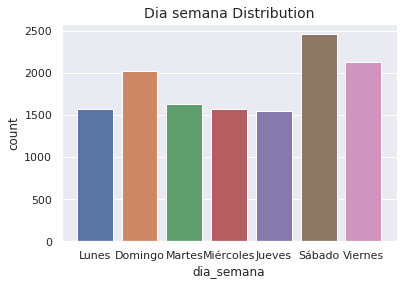

In [44]:
sns.countplot('dia_semana', data=incidents)
plt.title('Dia semana Distribution', fontsize=14)
plt.plot()

[]

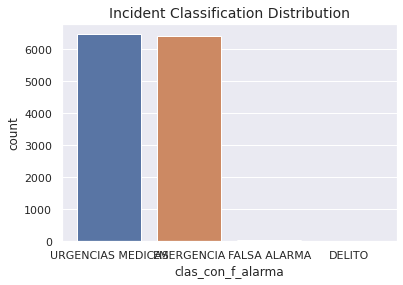

In [45]:
sns.countplot('clas_con_f_alarma', data=incidents)
plt.title('Incident Classification Distribution', fontsize=14)
plt.plot()

For the attribute `incidente_c4`, let's take advantage of the encoded attributes, in order to have better labels and see the distribution.

Number 0 is accidente-choque con lesionados
Number 1 is accidente-choque con prensados
Number 2 is accidente-choque sin lesionados
Number 3 is accidente-ciclista
Number 4 is accidente-ferroviario
Number 5 is accidente-motociclista
Number 6 is accidente-otros
Number 7 is accidente-persona atrapada / desbarrancada
Number 8 is accidente-vehiculo desbarrancado
Number 9 is accidente-vehículo atrapado-varado
Number 10 is accidente-volcadura
Number 11 is cadáver-accidente automovilístico
Number 12 is cadáver-atropellado
Number 13 is detención ciudadana-accidente automovilístico
Number 14 is detención ciudadana-atropellado
Number 15 is lesionado-atropellado
Number 16 is mi ciudad-calle-incidente de tránsito
Number 17 is sismo-choque con lesionados
Number 18 is sismo-persona atropellada


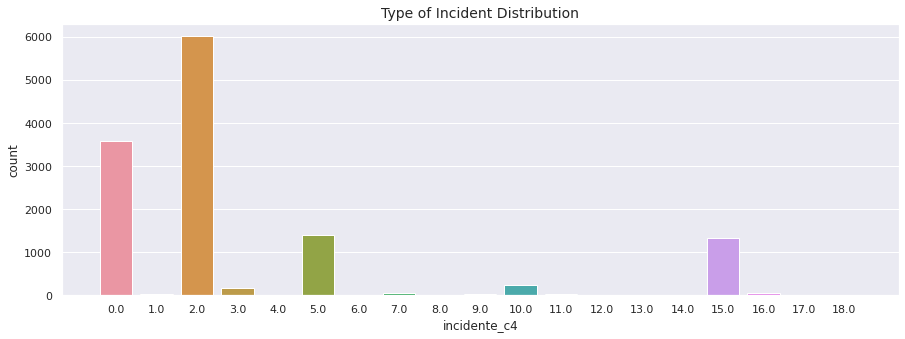

In [46]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot('incidente_c4', data=incidents_report_aux)
plt.title('Type of Incident Distribution', fontsize=14)
plt.plot()


for i, cat in enumerate(ordinal_encoder.categories_[2]):
  print('Number {} is {}'.format(i, cat))

Same case happens with `tipo_entrada`, let's see use the enconded attributes.

Number 0 is APLICATIVOS
Number 1 is BOTÓN DE AUXILIO
Number 2 is CÁMARA
Number 3 is LLAMADA APP911
Number 4 is LLAMADA DEL 911
Number 5 is RADIO
Number 6 is REDES


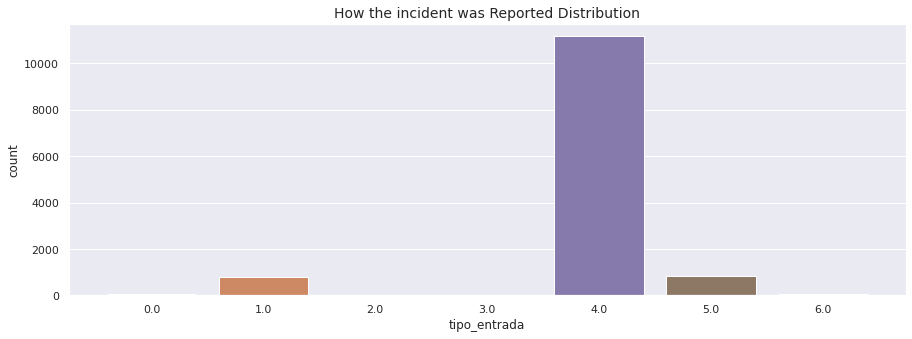

In [ ]:
sns.countplot('tipo_entrada', data=incidents_report_aux)
plt.title('How the incident was Reported Distribution', fontsize=14)
plt.plot()

for i, cat in enumerate(ordinal_encoder.categories_[3]):
  print('Number {} is {}'.format(i, cat))

## Exploring numerical attributes after preprocessing

Plot the `latitud` and `longitud` attributes with seaborn could be not a good idea, because of the large amount of data (geographical points). So the best approach was done previously using the scatter plot.

[]

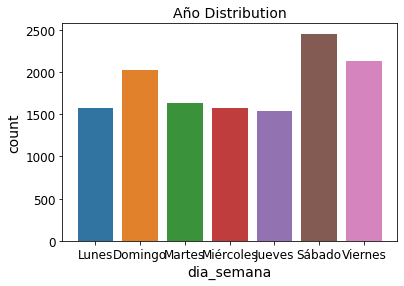

In [ ]:
sns.countplot('dia_semana', data=incidents)
plt.title('Año Distribution', fontsize=14)
plt.plot()

# Modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 300, max_depth=30, criterion = "gini", random_state = 42)
classifier.fit(X_train, y_train)

In [ ]:
y_pred  = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

# Report

# Deployment and consumption

# Useful resources
* https://www.educba.com/predictive-analysis-vs-forecasting/?source=leftnav